In [19]:
import torch

import torchvision

import torchvision.transforms as transforms

from torchvision.models import resnet18



# Transformações para os dados de treinamento e teste

transform = transforms.Compose(

    [transforms.ToTensor(),

     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])



# Baixando e carregando o dataset CIFAR-10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,

                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,

                                          shuffle=True, num_workers=2)



testset = torchvision.datasets.CIFAR10(root='./data', train=False,

                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=100,

                                         shuffle=False, num_workers=2)



# Carregando o modelo ResNet18 pré-treinado

model = resnet18(pretrained=True)



# Modificando a última camada para se ajustar ao CIFAR-10 (10 classes)

num_ftrs = model.fc.in_features

model.fc = torch.nn.Linear(num_ftrs, 10)



# Verificando o modelo

#print(model)

Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
from torch.utils.data import SubsetRandomSampler

import numpy as np



# Obtendo os índices de cada classe

targets = np.array(trainset.targets)

indices = np.arange(len(targets))

class_indices = [indices[targets == i] for i in range(10)]



# Definindo o tamanho do conjunto de validação por classe

val_size_per_class = 1



# Selecionando índices para o conjunto de validação e treino

val_indices = np.hstack([class_idx[:val_size_per_class] for class_idx in class_indices])

train_indices = np.hstack([class_idx[val_size_per_class:] for class_idx in class_indices])



# Criando samplers para os DataLoaders

train_sampler = SubsetRandomSampler(train_indices)

val_sampler = SubsetRandomSampler(val_indices)



# Criando DataLoaders para os novos conjuntos

unlabeledloader = torch.utils.data.DataLoader(trainset, batch_size=100, sampler=train_sampler, num_workers=2)

labeledloader = torch.utils.data.DataLoader(trainset, batch_size=100, sampler=val_sampler, num_workers=2)



# Verificando os tamanhos dos novos conjuntos

print(f'Tamanho do conjunto de treino: {len(train_indices)}')

print(f'Tamanho do conjunto de validação: {len(val_indices)}')

Tamanho do conjunto de treino: 49990
Tamanho do conjunto de validação: 10


In [21]:
import torch.nn as nn



class CustomResNet18(nn.Module):

    def __init__(self, num_classes=10):

        super(CustomResNet18, self).__init__()

        self.model = resnet18(pretrained=True)

        num_ftrs = self.model.fc.in_features

        self.model.fc = nn.Linear(num_ftrs, num_classes)



    def forward(self, x):

        return self.model(x)



# Instanciando a CNN customizada

custom_resnet18 = CustomResNet18(num_classes=10)



# Verificando a arquitetura do modelo

#print(custom_resnet18)

In [22]:
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, ColorJitter



weak_transform = transforms.Compose([

    RandomHorizontalFlip(),

    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

])



strong_transform = transforms.Compose([

    RandomHorizontalFlip(),

    RandomCrop(32, padding=4),

    ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),

    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

])


In [23]:
def generate_pseudo_labels(model, images, threshold=0.95):

    with torch.no_grad():

        outputs = model(images)

        probabilities, pseudo_labels = torch.max(torch.softmax(outputs, dim=1), dim=1)

        mask = probabilities >= threshold

    return pseudo_labels[mask], mask


In [24]:
criterion = nn.CrossEntropyLoss()



def fixmatch_loss(outputs, labels, pseudo_outputs, pseudo_labels, mask, un_tax=0.5):

    # Perda supervisionada

    supervised_loss = criterion(outputs, labels)



    # Perda não supervisionada

    unsupervised_loss = criterion(pseudo_outputs[mask], pseudo_labels)



    # Combinação das perdas (pode-se ajustar o peso da perda não supervisionada)

    total_loss = supervised_loss + un_tax * unsupervised_loss

    return total_loss


In [25]:
import matplotlib.pyplot as plt
import random

# Função para exibir três imagens com as respectivas predições do modelo
def show_random_images_with_predictions(images, labels, model):
    # Seleciona três índices aleatórios
    indices = random.sample(range(images.size(0)), 3)
    
    model.eval()
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        # Extrai a imagem e o rótulo verdadeiros
        image = images[idx]
        label = labels[idx].item()
        
        # Obtém a predição do modelo
        with torch.no_grad():
            output = model(image.unsqueeze(0))
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()
        
        # Converte a imagem para formato exibível
        image_np = image.permute(1, 2, 0).numpy()  # Reorganiza para H x W x C
        image_np = (image_np * 0.2023 + 0.4914)  # Desnormaliza para faixa 0-1
        
        # Exibe a imagem e predições
        plt.subplot(1, 3, i + 1)
        plt.imshow(image_np)
        plt.title(f'True: {label}, Predicted: {predicted_label}')
        plt.axis('off')
    
    plt.show()

Epoch 1/50
1
Results at Epoch 1


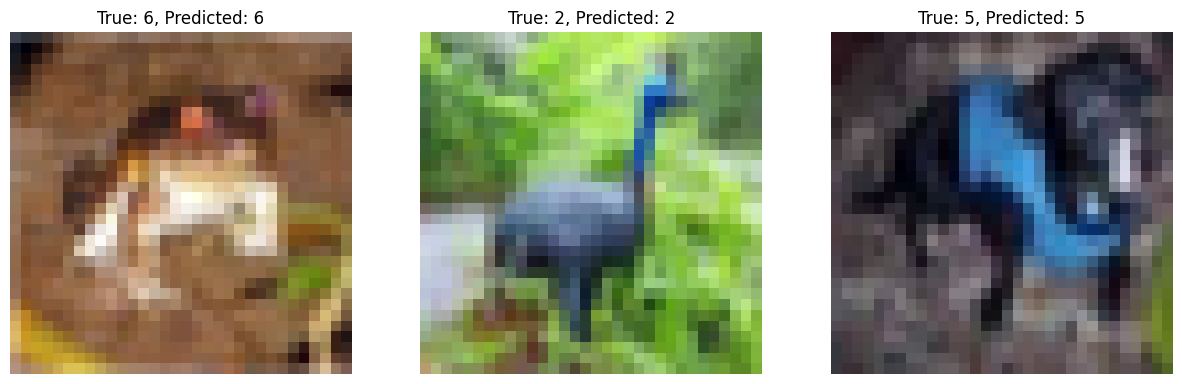

Epoch 2/50
1
Epoch 3/50
1
Epoch 4/50
1
Epoch 5/50
1
Results at Epoch 5


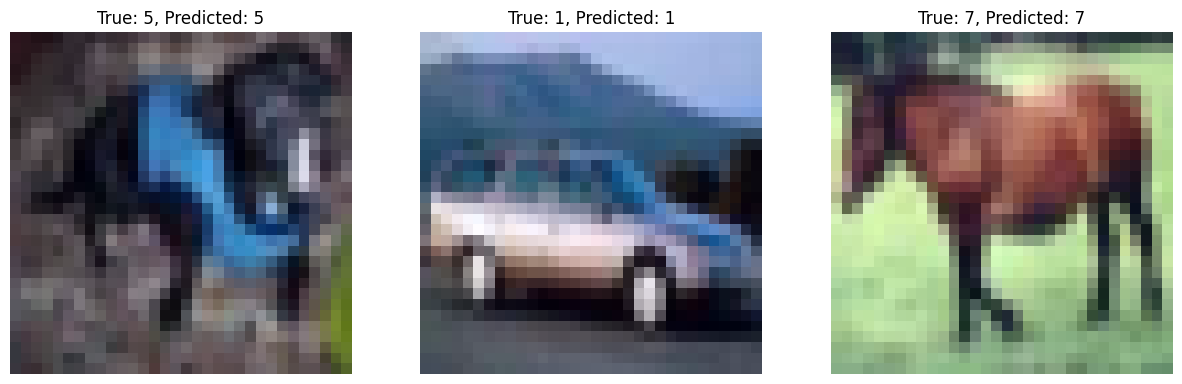

Epoch 6/50
1
Epoch 7/50
1
Epoch 8/50
1
Epoch 9/50
1
Epoch 10/50
1
Results at Epoch 10


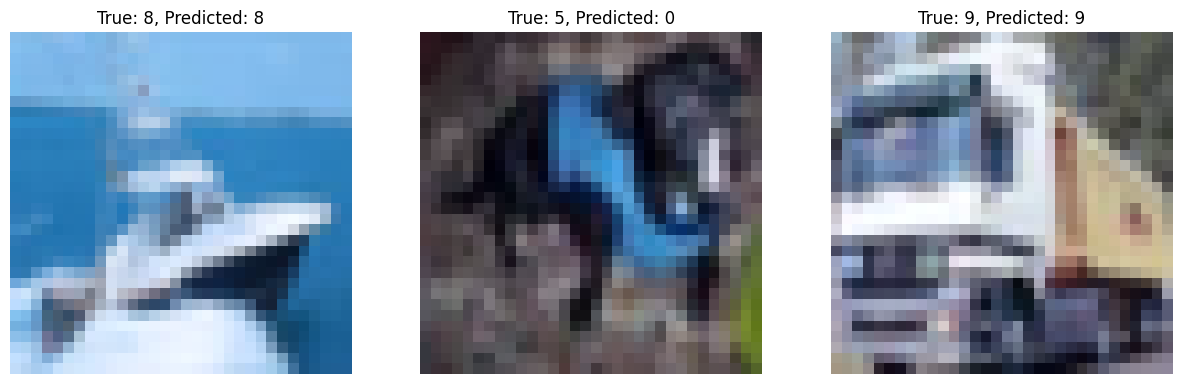

Epoch 11/50
1
Epoch 12/50
1
Epoch 13/50
1
Epoch 14/50
1
Epoch 15/50
1
Results at Epoch 15


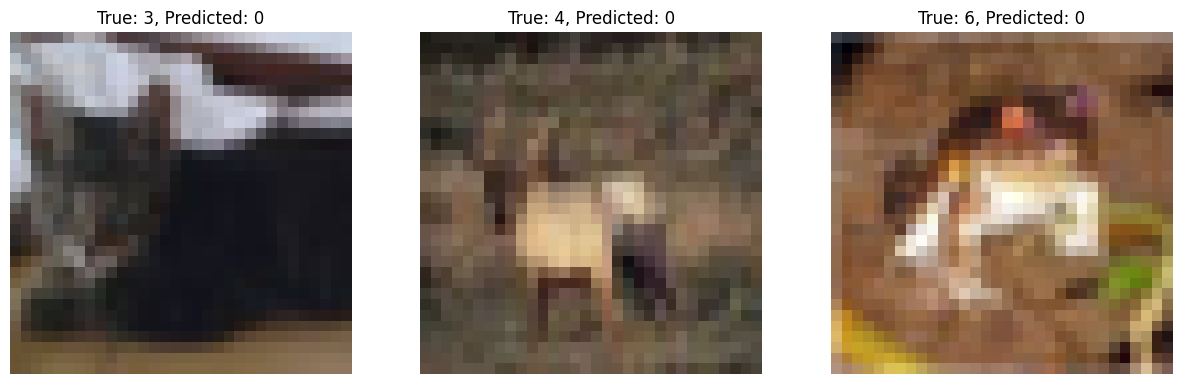

Epoch 16/50
1
Epoch 17/50
1
Epoch 18/50
1
Epoch 19/50
1
Epoch 20/50
1
Results at Epoch 20


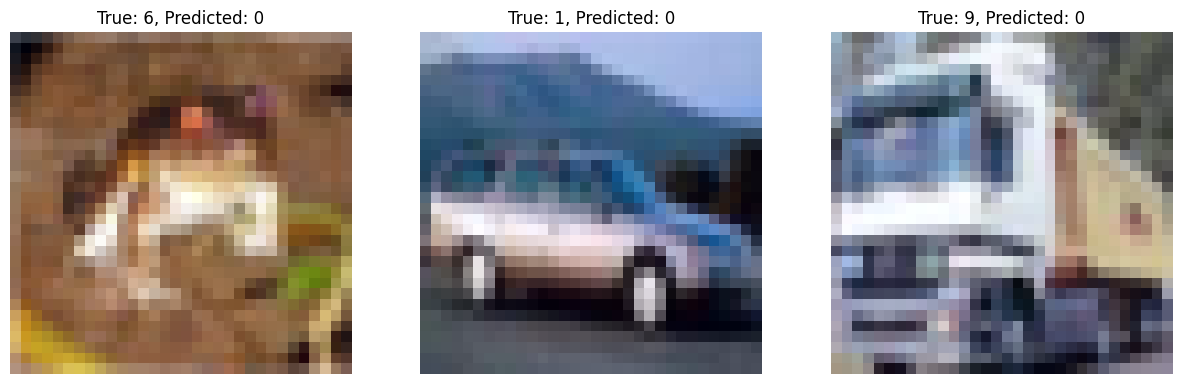

Epoch 21/50
1
Epoch 22/50
1
Epoch 23/50
1
Epoch 24/50
1
Epoch 25/50
1
Results at Epoch 25


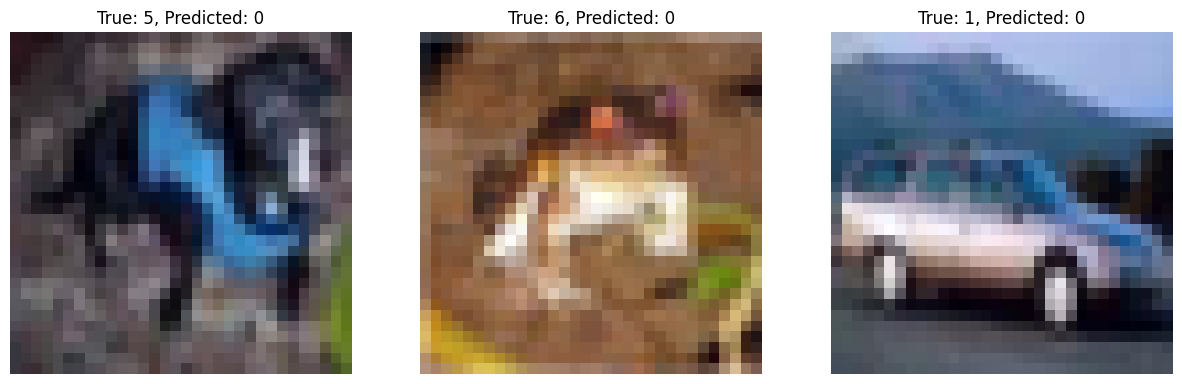

Epoch 26/50
1
Epoch 27/50
1
Epoch 28/50
1
Epoch 29/50
1
Epoch 30/50
1
Results at Epoch 30


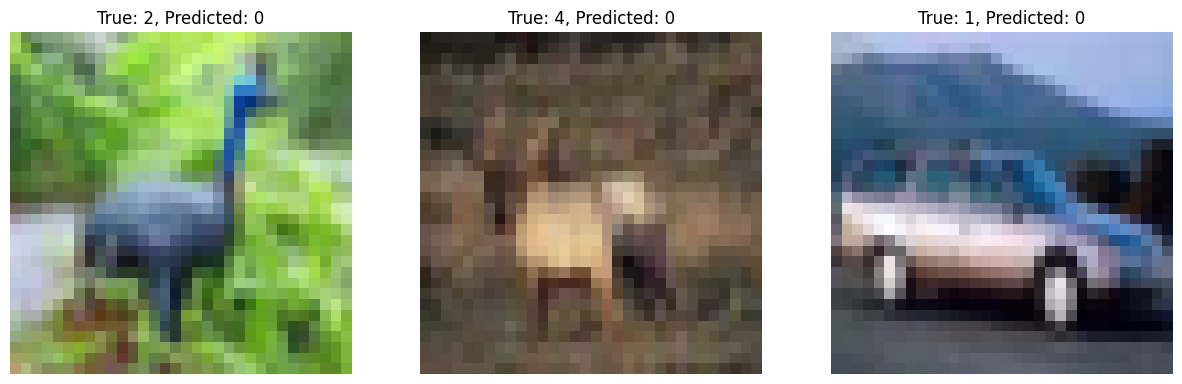

Epoch 31/50
1
Epoch 32/50
1
Epoch 33/50
1
Epoch 34/50
1
Epoch 35/50
1
Results at Epoch 35


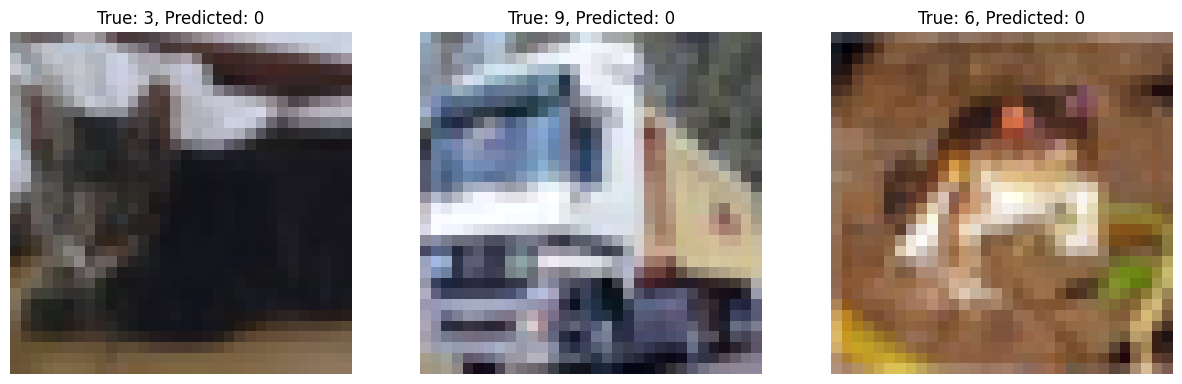

Epoch 36/50
1
Epoch 37/50
1
Epoch 38/50
1
Epoch 39/50
1
Epoch 40/50
1
Results at Epoch 40


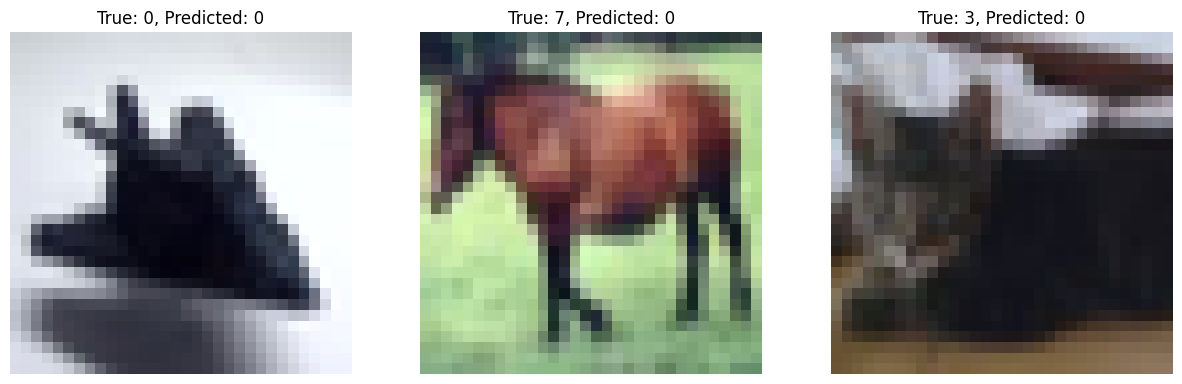

Epoch 41/50
1
Epoch 42/50
1
Epoch 43/50
1
Epoch 44/50
1
Epoch 45/50
1
Results at Epoch 45


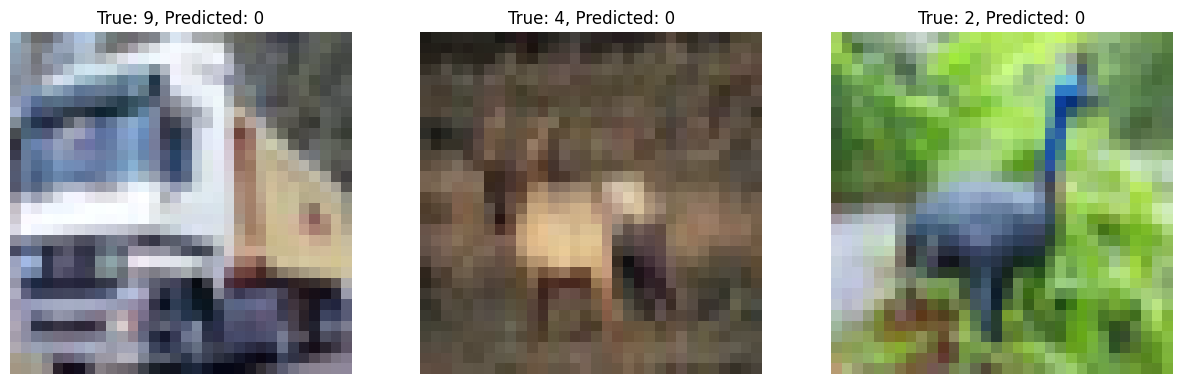

Epoch 46/50
1
Epoch 47/50
1
Epoch 48/50
1
Epoch 49/50
1
Epoch 50/50
1
Results at Epoch 50


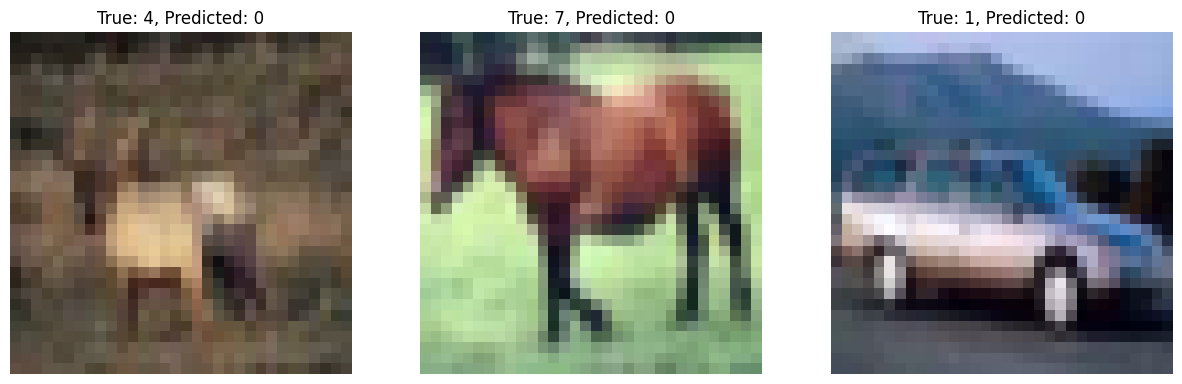

In [26]:

optimizer = torch.optim.Adam(custom_resnet18.parameters(), lr=0.001)



num_epochs = 50
un_tax = 0.5
threshold = 0.8


# Inicialize listas para armazenar as perdas ao longo do treinamento

supervised_losses = []

unsupervised_losses = []

total_losses = []



# Durante o loop de treinamento, após calcular a perda, armazene os valores

for epoch in range(num_epochs):

    print(f'Epoch {epoch + 1}/{num_epochs}')

    custom_resnet18.train()

    epoch_supervised_loss = 0.0

    epoch_unsupervised_loss = 0.0

    epoch_total_loss = 0.0

    num_batches = 0



    for (images, labels), (unlabeled_images, _) in zip(labeledloader, unlabeledloader):

        # Calcule as perdas como antes

        outputs = custom_resnet18(images)

        labeled_loss = criterion(outputs, labels)

        

        weak_images = weak_transform(unlabeled_images)

        strong_images = strong_transform(unlabeled_images)

        pseudo_labels, mask = generate_pseudo_labels(custom_resnet18, weak_images, threshold)

        

        if mask.sum() > 0:

            pseudo_outputs = custom_resnet18(strong_images)

            total_loss = fixmatch_loss(outputs, labels, pseudo_outputs, pseudo_labels, mask, un_tax)

            unsupervised_loss = criterion(pseudo_outputs[mask], pseudo_labels).item()

        else:

            total_loss = labeled_loss

            unsupervised_loss = 0.0  # Sem pseudo-rótulos, perda não supervisionada é zero



        supervised_loss = labeled_loss.item()

        epoch_supervised_loss += supervised_loss

        epoch_unsupervised_loss += unsupervised_loss

        epoch_total_loss += total_loss.item()

        

        num_batches += 1



        # Otimização

        optimizer.zero_grad()

        total_loss.backward()

        optimizer.step()



    # Armazene a média das perdas por época
    print(num_batches)
    supervised_losses.append(epoch_supervised_loss / num_batches)

    unsupervised_losses.append(epoch_unsupervised_loss / num_batches)

    total_losses.append(epoch_total_loss / num_batches)

    
    # Exibe uma imagem e a predição a cada 5 épocas
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Results at Epoch {epoch + 1}")
        show_random_images_with_predictions(images, labels, custom_resnet18)


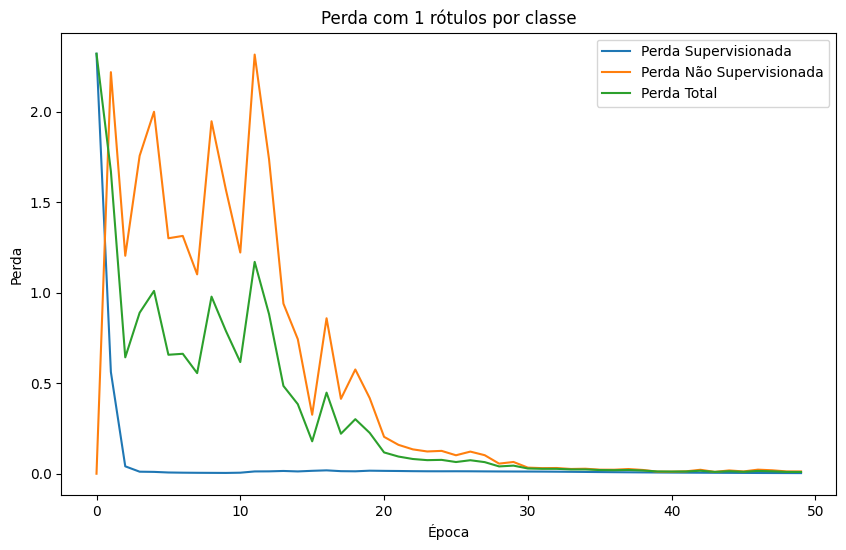

In [27]:
# Plotando o gráfico de perda ao final do treinamento

plt.figure(figsize=(10, 6))

plt.plot(supervised_losses, label="Perda Supervisionada")

plt.plot(unsupervised_losses, label="Perda Não Supervisionada")

plt.plot(total_losses, label="Perda Total")

plt.xlabel("Época")

plt.ylabel("Perda")

plt.title(f"Perda com {val_size_per_class} rótulos por classe")

plt.legend()

plt.show()


In [28]:
from sklearn.metrics import accuracy_score

# Certifique-se de que o modelo está em modo de avaliação
custom_resnet18.eval()
all_preds = []
all_labels = []

# Desativa o cálculo de gradiente para a avaliação
with torch.no_grad():
    for images, labels in testloader:
        outputs = custom_resnet18(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calcula a acurácia
accuracy = accuracy_score(all_labels, all_preds)
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")


Acurácia no conjunto de teste: 10.00%
